In [2]:
from models.FC_models import *

In [6]:
PATCH_SIZE = 8

model_path = "saved_models/mikmik_fc_res-p8_b16-1_100.pkl"
model = Residual2CoreFC(coded_size=16,
                        patch_size=PATCH_SIZE,
                        num_passes=4)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Train set

In [7]:
import torchvision
import torchvision.transforms as transforms

# Normalize function so given an image of range [0, 1] transforms it into a Tensor range [-1. 1]
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR LOADER
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)

dataiter = iter(train_loader)

Files already downloaded and verified


In [57]:


from evaluation import to_patches, reconstruct_patches

imgs, labels = next(dataiter)
print(labels[0])

patches = to_patches(imgs, PATCH_SIZE)
r_patches = []
model.sample(patches[0])

r_patches = [model.sample(p) for p in patches] # Reconstructed Patches

reconstructed = reconstruct_patches(r_patches)

tensor(10)


In [58]:
import numpy as np

def imsave(img, name, path, saving_path=None):
    img = img / 2 + 0.5     # unnormalize
    #saving_path = os.path.join(args.output_path, name+'.png')
    print(f"saving to {saving_path }")
    torchvision.utils.save_image(img, saving_path)

def imshow(img, name, ax=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    if ax:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


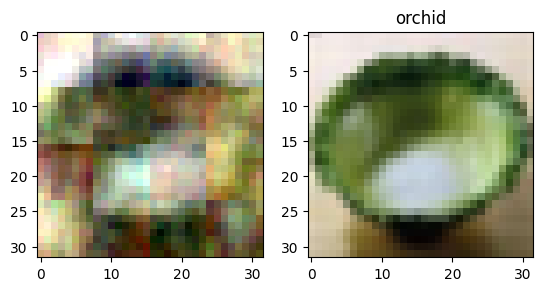

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [59]:
import matplotlib.pyplot as plt

# show image alongside original
f, axarr = plt.subplots(1, 2)
plt.title(classes[labels[0]])
imshow(reconstructed[0], "reconstructed", ax=axarr[0])
imshow(imgs[0], "original", ax=axarr[1])

In [16]:
superclass = [['beaver', 'dolphin', 'otter', 'seal', 'whale'],
              ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
              ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
              ['bottle', 'bowl', 'can', 'cup', 'plate'],
              ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
              ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
              ['bed', 'chair', 'couch', 'table', 'wardrobe'],
              ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
              ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
              ['bridge', 'castle', 'house', 'road', 'skyscraper'],
              ['cloud', 'forest', 'mountain', 'plain', 'sea'],
              ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
              ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
              ['crab', 'lobster', 'snail', 'spider', 'worm'],
              ['baby', 'boy', 'girl', 'man', 'woman'],
              ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
              ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
              ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
              ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
              ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']]

classes = sum(superclass, [])
print(classes)

['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium_fish', 'flatfish', 'ray', 'shark', 'trout', 'orchid', 'poppy', 'rose', 'sunflower', 'tulip', 'bottle', 'bowl', 'can', 'cup', 'plate', 'apple', 'mushroom', 'orange', 'pear', 'sweet_pepper', 'clock', 'keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf', 'bridge', 'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab', 'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 'woman', 'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 'maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree', 'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train', 'lawn_mower', 'rocket', 'stree

# Classifier

In [ ]:
classifier = torchvision.models.resnet18(pretrained=True, num_classes=100)